In [120]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from typing import List
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_pickle("../data/data_clean.pkl")
n = df.shape[0]

# set up text for prediction
def get_text_representation(row):
    # return f"""- Title: {row["title"]}
# - Description: {row["description"]}
# - Predictor variables: {str(row["feature_names"])[1:-1]}"""
    return f"""{row["title"]}. {row["description"]}"""
df['text'] = df.apply(get_text_representation, axis=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
def id_to_idx(id, df):
    return np.where(df.id == id)[0]


sims = np.zeros((n, n))
for r, row in tqdm(df.iterrows()):
    ids = row["info___related_calc_ids"]
    for id in ids:
        c = id_to_idx(id, df)
        sims[r, c] += 1

    # for c, col in df.iterrows():
    #     for key in [
    #         "categorization___chief_complaint",
    #         "categorization___specialty",
    #         "categorization___purpose",
    #         "categorization___system",
    #         "categorization___disease",
    #     ]:
    #         if row[key] == col[key]:
    #             sims[r, c] += 1


# average values across the diagonal
sims = (sims + sims.T) / 2

# set diagonal to 1
# np.fill_diagonal(sims, max(sims))

# plot clustermap
# sns.clustermap(sims)

0it [00:00, ?it/s]

690it [00:00, 3668.10it/s]


In [123]:
def get_embs(
    texts: List[str], checkpoint: str = "bert-base-uncased", batch_size: int = 32
) -> np.ndarray:
    
    # load model
    # get embeddings for each text from the corpus
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    model = AutoModel.from_pretrained(checkpoint)

    # calculate embeddings
    embs = []
    for i in tqdm(range(0, len(df), batch_size)):
        t = texts[i : i + batch_size]
        with torch.no_grad():
            # tokenize
            inputs = tokenizer(t, return_tensors="pt", padding=True, truncation=True)
            # Shape: [batch_size, seq_len, hidden_size]
            outputs = model(**inputs).last_hidden_state.detach().cpu().numpy()
            emb = np.mean(outputs, axis=1).squeeze()  # average over sequence length
            # emb = outputs[:, 0, :].squeeze()  # use CLS token
            embs.append(emb)
    embs = np.concatenate(embs)
    return embs


checkpoint = "bert-base-uncased"
# checkpoint = 'microsoft/deberta-v2-xxlarge'
embs = get_embs(df["text"].tolist(), checkpoint, batch_size=32)

100%|██████████| 22/22 [00:04<00:00,  4.44it/s]


In [127]:
def get_embs_linear(texts: List[str]) -> np.ndarray:
    """Get TF-IDF vectors for a list of texts.

    Args:
        texts (List[str]): List of texts to get TF-IDF vectors for.
        checkpoint (str, optional): Checkpoint to use for the TF-IDF vectorizer. Defaults to "bert-base-uncased".
        batch_size (int, optional): Batch size to use for the TF-IDF vectorizer. Defaults to 32.

    Returns:
        np.ndarray: TF-IDF vectors for the input texts.
    """
    vectorizer = TfidfVectorizer(
        tokenizer=AutoTokenizer.from_pretrained(checkpoint).tokenize,
        preprocessor=lambda x: x,
        token_pattern=None,
        lowercase=False,
        max_features=10000,
    )
    return vectorizer.fit_transform(texts).toarray()
embs = get_embs_linear(df["text"].tolist())

326.18 344.5


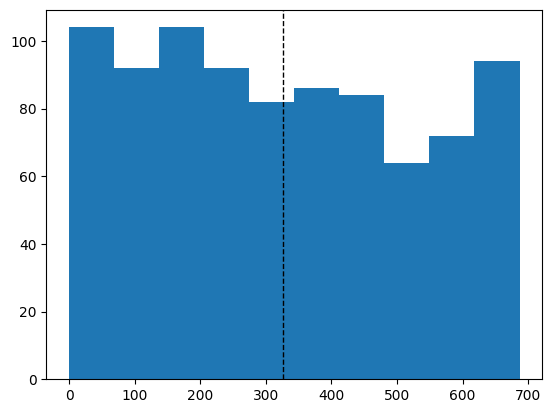

In [129]:
# calculate pairwise similarity between all embeddings in embs
s = cosine_similarity(embs)

# ranks for largest values in each row (0 is best rank)
ranks = np.argsort(s, axis=1)[:, ::-1]

# matrix showing gt
sims_sym = (sims >= 1.0).astype(bool)

# select ranks for gt
ranks_for_gt = []
for i in range(sims_sym.shape[0]):
    ranks_for_gt.append(ranks[i][sims_sym[i]])

# look at ranks
all_ranks = np.concatenate(ranks_for_gt) - 1
plt.hist(all_ranks)
mean_rank = np.mean(all_ranks).round(2)
plt.axvline(mean_rank, color="k", linestyle="dashed", linewidth=1)
print(mean_rank, (ranks.shape[1] - 1) / 2)